# Session 12 - Regression

## Session agenda
1. Formulating regression problem: linear, polynomial and nonlinear regression.
2. Using scipy.optimize to solve special cases of nonlinear least squares problems.
3. Overview of regression algorithms in scikit-learn. Validating regression results.
4. Model selection and regularization.
5. Combining data with structural models. 

## Formulating regression problem

### Linear regression
We will start with a simple example of linear regression, provided by scikit-learn. This example present the basic workflow of how regression problem can be solved with scikit-learn.

Automatically created module for IPython interactive environment
Coefficients: 
 [ 938.23786125]
Mean squared error: 2548.07
Variance score: 0.47


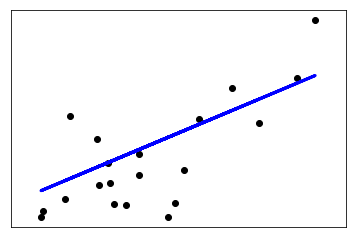

In [2]:
print(__doc__)

# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Polynomial regression
Usually the process or relation, described by the data is more complex. In this case linear model can be inappropriate. Still we can use linear model to our benefit. We can approximate underlying non-linear process or relation with a polynomial function of certain order and the make a reduction to the linear model by introducing new regression parameters for the non-linear terms. For this purpose, you can use polynomial features transformer on the initial data, which we covered in Session 11.

### Non-linear regression
There are certain cases, when polynomial approximation can't be used and instead the nonlinear function is used to perform parametric regression. In this case we need to formulate the underlying minimization problem ourselves. We can do it with scipy.optimize 

(array([ 2.1070562 ,  0.10761017,  0.65308373]), 1)


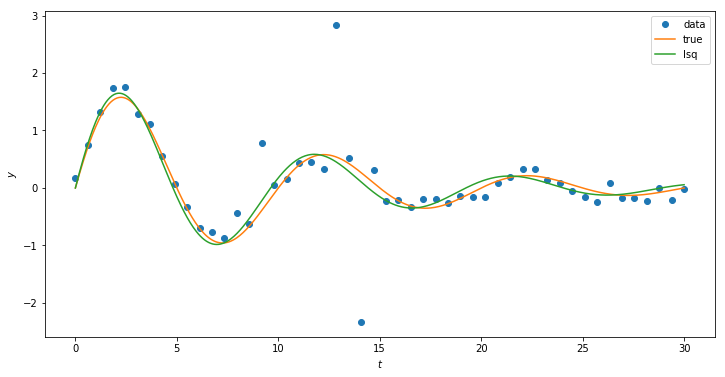

In [29]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import leastsq

def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error

A = 2
sigma = 0.1
omega = 0.1 * 2 * np.pi
x_true = np.array([A, sigma, omega])

noise = 0.1

t_min = 0
t_max = 30

t_train = np.linspace(t_min, t_max, 50)
y_train = generate_data(t_train, A, sigma, omega, noise=noise, n_outliers=4)

t_test = np.linspace(t_min, t_max, 600)
y_test = generate_data(t_test, A, sigma, omega)

def fun(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y

x0 = np.ones(3)
res_lsq = leastsq(fun, x0, args=(t_train, y_train))
print(res_lsq)

y_lsq = generate_data(t_test, *res_lsq[0])

plt.figure(figsize=(12,6))

plt.plot(t_train, y_train, 'o', label='data')
plt.plot(t_test, y_test, label='true')
plt.plot(t_test, y_lsq, label='lsq')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()

plt.show()

## Validating regression results
Once we have fitted our model to the data, we have to analyze the quality of the results. Depending on the assumptions we make about the model and provided data, different tests can be perfomed. Usually tests for goodness-of-fit of the model and  statistical significance of the estimated parameters are performed. Additionally, hypothesis tests are used to additionally check different parameters of the acquired results (e.g. we might want to check, that regression residuals follow a certain distribution with given parameters).

Reference:

1. https://en.wikipedia.org/wiki/Goodness_of_fit
2. https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test
3. https://en.wikipedia.org/wiki/Coefficient_of_determination
4. https://en.wikipedia.org/wiki/Errors_and_residuals

## Overfitting and underfitting
When the model we select "mismatches" provided data, we can run into two types of problems:

1. Overfitting. The model is too complex, so it is possible to "tune" the model to the provided data but at the expence of the increased variance. The model basically "memories" provided data, but fails to generelize it. Thus, it exhibits the following behavior: it give no error on the provided data, but the error on the observed data can have significant variance. 

2. Underfitting. The model is too simple, so it can't capture the underlying functional dependency, which provided data exhibits. In this case the model will show low variance, but a high bias.

Reference:
1. https://en.wikipedia.org/wiki/Overfitting 

Automatically created module for IPython interactive environment


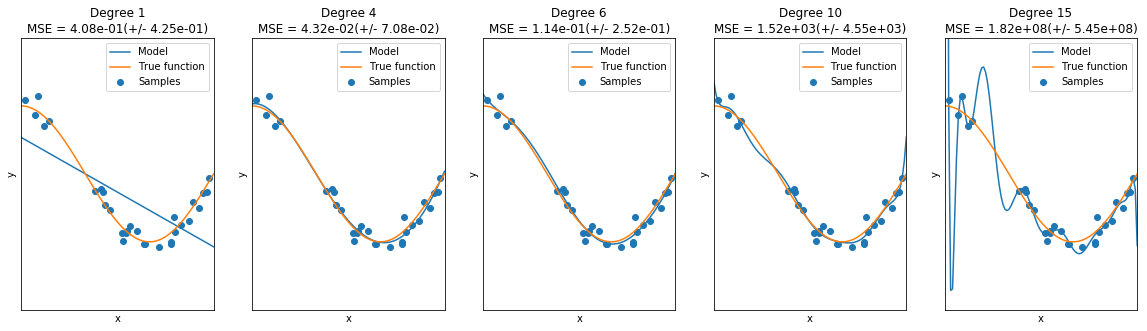

In [57]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 6, 10, 15] #You can change the list of degrees here

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(20, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Regularization
In the example above we have seen, that cardinality of the polynomial regression model can significantly affect the results. Thus, we need a way to select the right model, which delivers the best possible generelization of the provided data. We can do a grid search, testing all possible cardinalities (basically, we did that manually in the previous example).

Another approach is to use regularization. An interesting approach, which introduces a modification of the initial regression problem that allow to automatically select the model. The function in the regression formulation is "regularized" with a special funciton ("regulizer"), which limits the values of regression parameters. Thus, the impact of the higher-order terms on the resulting function can be limited. 

Different types of regulizers can be used and usually regulizers introduce their own hyperparameters.


Tikhonov regulizer is one of the classical which can be used for the regularization of the regression problem. It is also know as ridge regression.

Reference:

1. https://en.wikipedia.org/wiki/Regularization_(mathematics)
2. http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html#sphx-glr-auto-examples-linear-model-plot-ridge-coeffs-py
3. http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

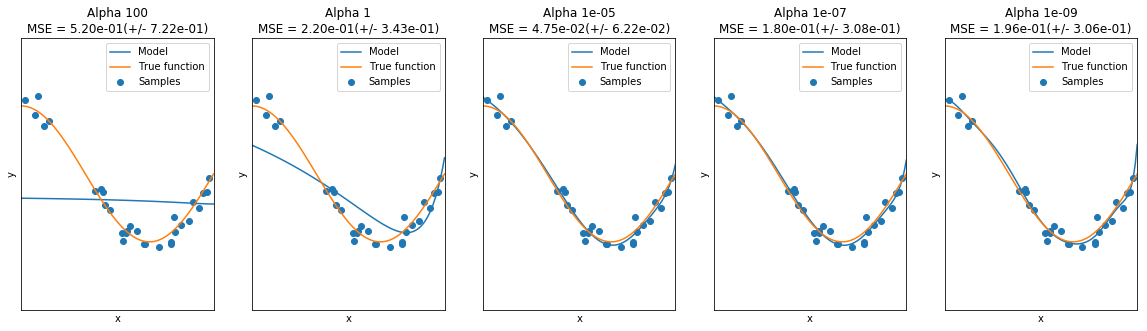

In [58]:
#We will be reusing data from the previous example, so check that you have all the cells processed accordingly
from sklearn.linear_model import Ridge 

regularization_strength_list = [100, 1, 0.00001, 0.0000001, 0.000000001] #You can change regularization strength here
degree = 15 #You can change degree of the polynomial used for the regression here

plt.figure(figsize=(20, 5))

for i, regularization_strength in enumerate(regularization_strength_list):
    ax = plt.subplot(1, len(regularization_strength_list), i+1 )
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree,
                                             include_bias=False)
    ridge_regression = Ridge(alpha=regularization_strength)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("ridge_regression", ridge_regression)])
    
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Alpha {}\nMSE = {:.2e}(+/- {:.2e})".format(
        regularization_strength, -scores.mean(), scores.std()))
plt.show()

## Combining regression with structural models
All the examples of regression, which we have discussed were unstructured. We have never limited the choise of the model and tried to select the best possible model, which we could fit into our model. Regression can be coupled with structural models, when we have some additional information about the underlying process, which produced analysed data. This information forms the structural model and comes in the form of restrictions to the function, which we are fitting to the provided data.

Usually, structural models limit us to the parametric families of functions and in some cases function is defined implicitly in a form of algorithm or calculation routine. 

In [1]:
#Example or showcase of OpenFLUX2